# Fake Job Postings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt install enchant
!pip install pyenchant

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upgraded, 10 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,312 kB of archives.
After this operation, 5,353 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libtext-iconv-perl amd64 1.7-5build6 [

In [3]:
# Libraries used
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import matplotlib.pyplot as plt
import imblearn.over_sampling
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
import enchant
import statsmodels.api as sm
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# EDA

In [4]:
# We'll now upload the original preprocessed dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fake_job_postings.csv')

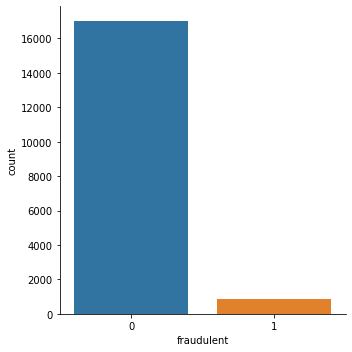

In [ ]:
sns.catplot(x="fraudulent", data = df, kind = "count");

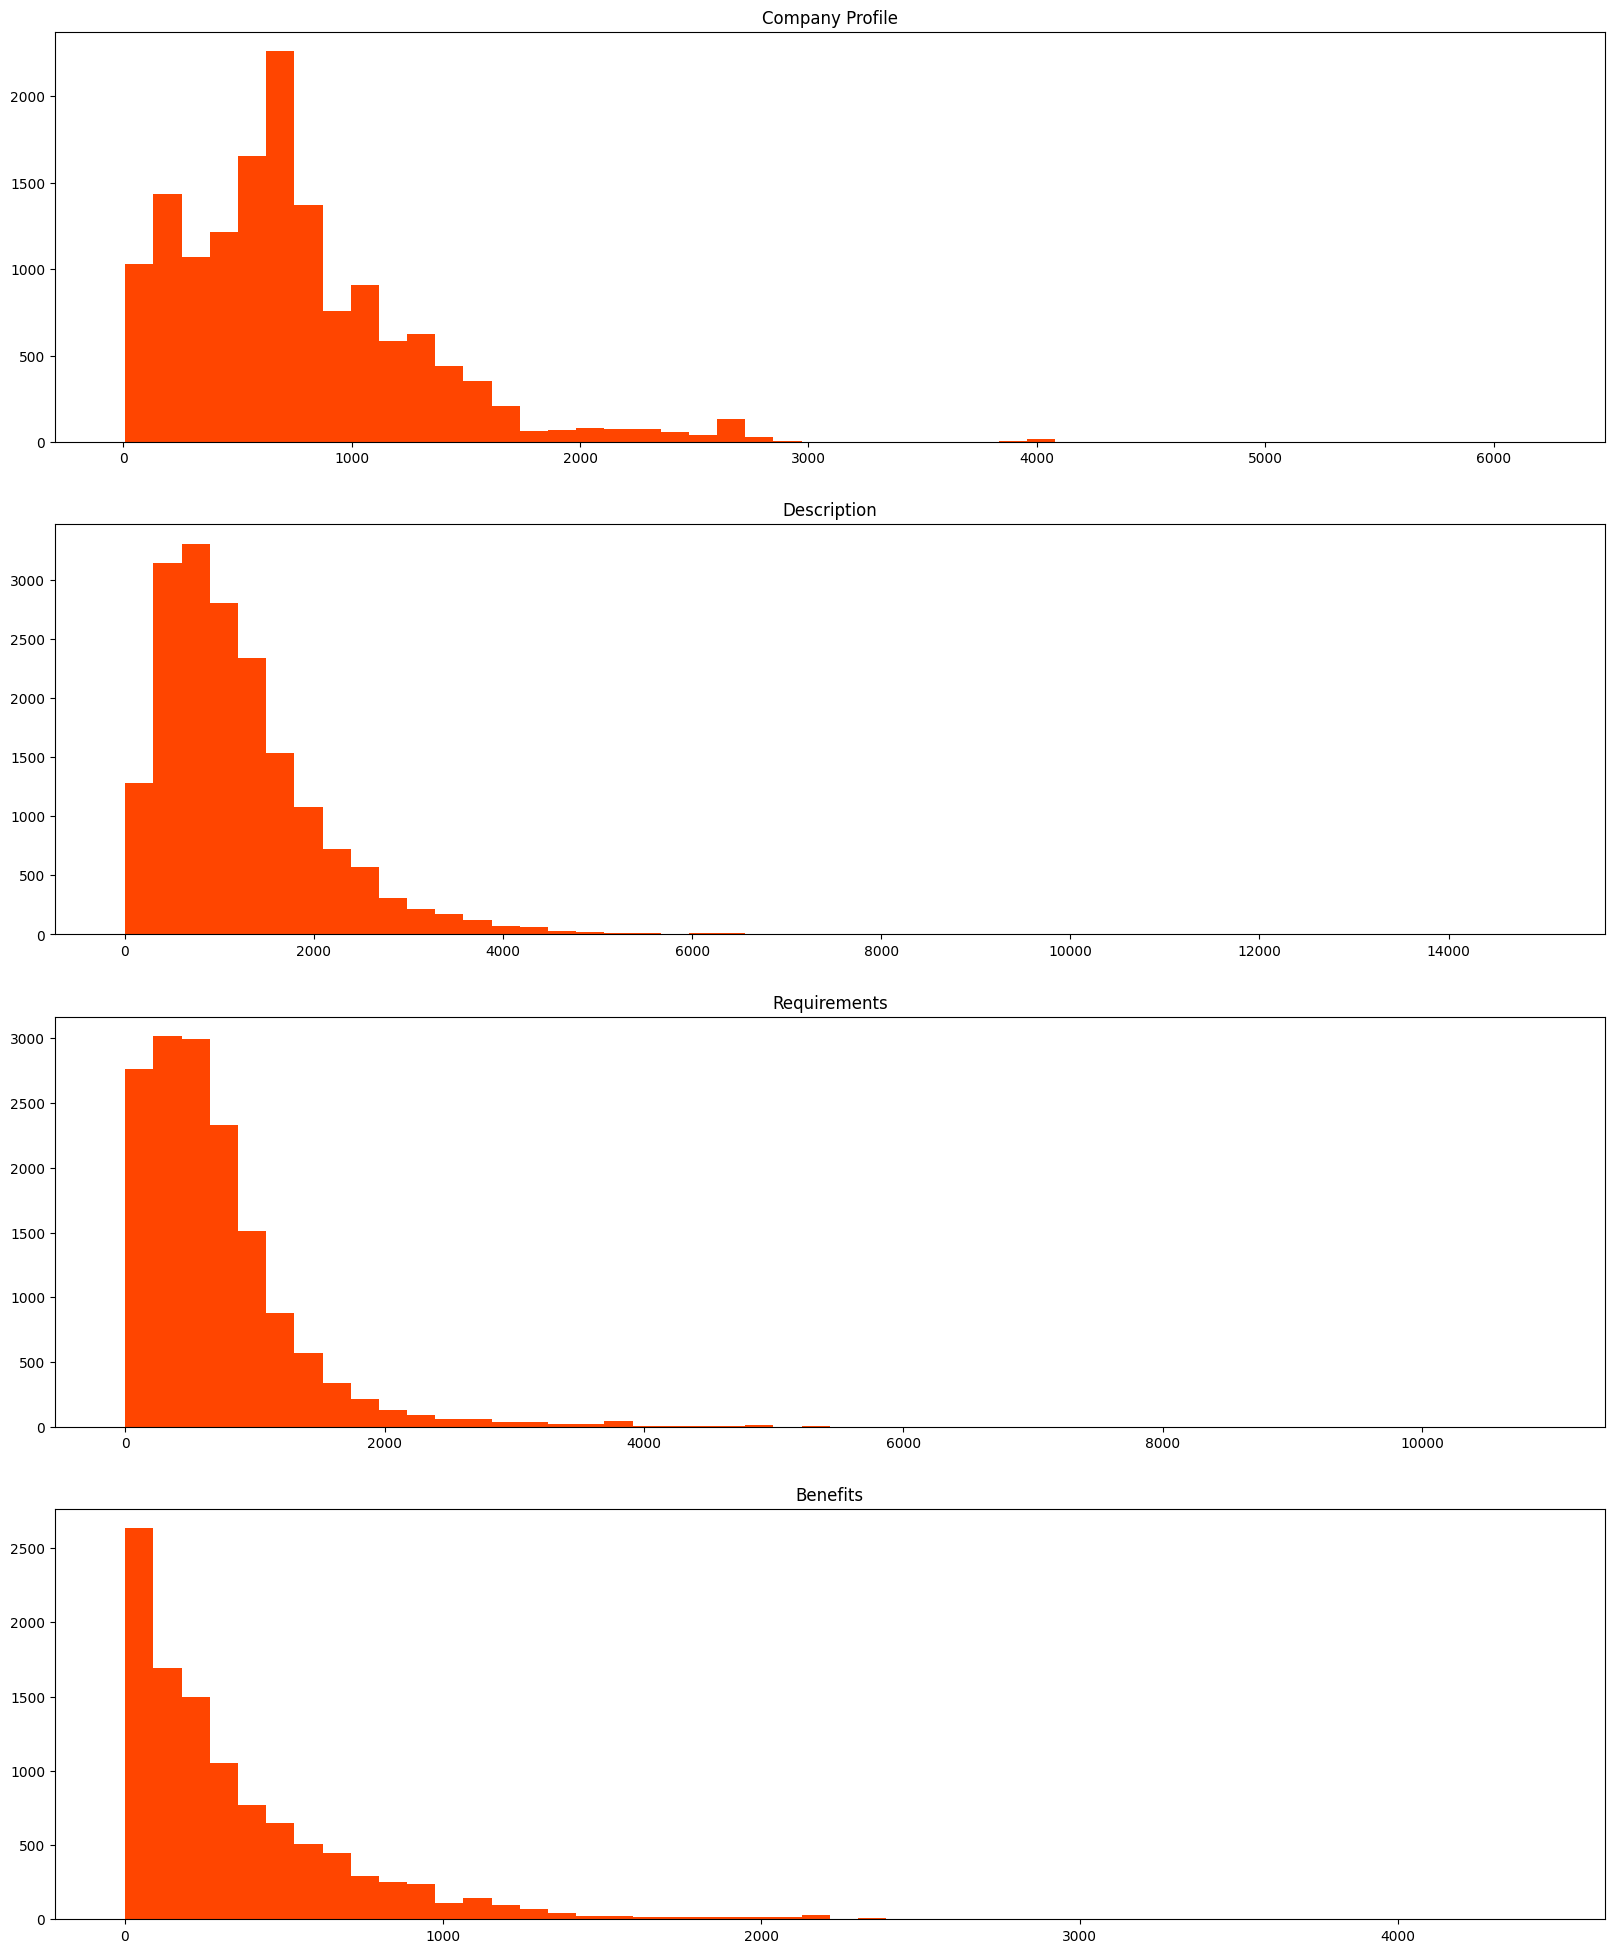

In [ ]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(ncols=1, nrows=4, figsize=(20, 25), dpi=100)

#counting the number of characters in company_profile column
length=df['company_profile'].str.len()
ax1.hist(length,bins = 50, color='orangered')
ax1.set_title('Company Profile')

#counting the number of characters in description column
length=df['description'].str.len()
ax2.hist(length,bins = 50, color='orangered')
ax2.set_title('Description')

#counting the number of characters in requirements column
length=df['requirements'].str.len()
ax3.hist(length,bins = 50, color='orangered')
ax3.set_title('Requirements')

#counting the number of characters in benefits column
length=df["benefits"].str.len()
ax4.hist(length, bins = 50, color='orangered')
ax4.set_title('Benefits')

plt.show();

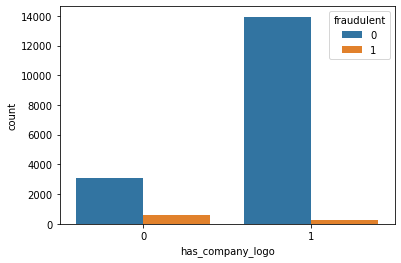

In [ ]:
sns.countplot(x ="has_company_logo", hue="fraudulent", data=df);

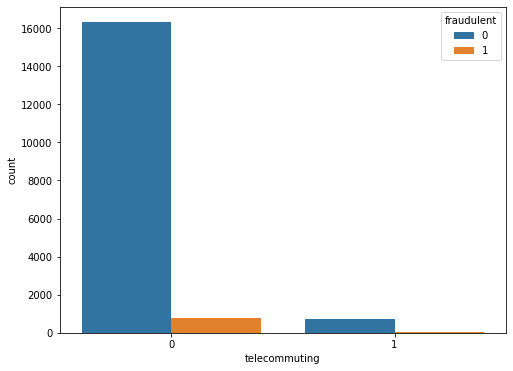

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='telecommuting',hue='fraudulent',data=df)

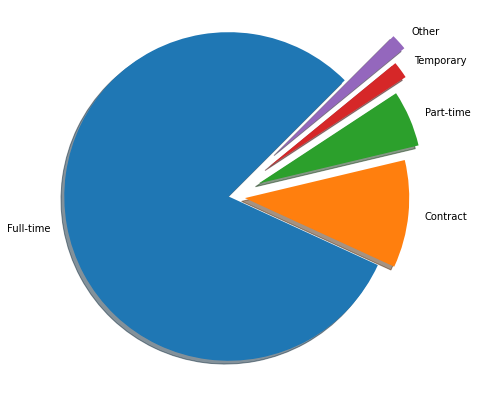

In [ ]:
labels = ['Full-time','Contract','Part-time','Temporary','Other']
sizes =[df['employment_type'].value_counts()[x] for x in range(5)]
explode = (0,0.1,0.2,0.3,0.4)

#plot
plt.figure(figsize=(7,7))
plt.pie(sizes,labels=labels,explode=explode,
       shadow=True,startangle=45)
plt.axis('equal')
plt.show()

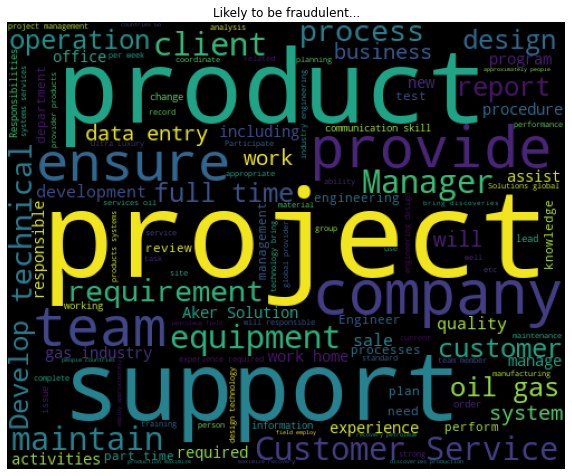

In [ ]:
from wordcloud import WordCloud 
x =df[df['fraudulent']==1]

# word cloud of the job description 
words = x['description'][~pd.isnull(x['description'])]
wordcloud = WordCloud(width=500,height=400).generate(''.join(words))

plt.figure(figsize=(10,12))
plt.axis('off')
plt.title('Likely to be fraudulent...')
plt.imshow(wordcloud)
plt.show()

## Data Cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [ ]:
df.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


In [ ]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [ ]:
# We have to be carefull when selecting how to deal with Nans to avoid significant drop in minority data
a = df[~df.description.isna()]
b = df[~df.company_profile.isna()]
c = df[~df.requirements.isna()]
d = df[~df.benefits.isna()]
e = df[~df.isna()]
f = df[~df.salary_range.isna()]
g = df[~df.telecommuting.isna()]
h = df[~df.has_company_logo.isna()]
i = df[~df.has_questions.isna()]
j = df[~df.employment_type.isna()]
k = df[~df.required_education.isna()]
l = df[~df.required_experience.isna()]

print('Original:           ',df.shape, df[df.fraudulent == 1].shape, df[df.fraudulent == 0].shape)
print('Description:        ',a.shape, a[a.fraudulent == 1].shape, a[a.fraudulent == 0].shape)
print('Company Profile:    ',b.shape, b[b.fraudulent == 1].shape, b[b.fraudulent == 0].shape)
print('Requirements:       ',c.shape, c[c.fraudulent == 1].shape, c[c.fraudulent == 0].shape)
print('Benefits:           ',d.shape, d[d.fraudulent == 1].shape, d[d.fraudulent == 0].shape)
print('Salary Range:       ',f.shape, f[f.fraudulent == 1].shape, f[f.fraudulent == 0].shape)
print('Telecommuting:      ',g.shape, g[g.fraudulent == 1].shape, g[g.fraudulent == 0].shape)
print('Has Company Logo:   ',h.shape, h[h.fraudulent == 1].shape, h[h.fraudulent == 0].shape)
print('Has Questions:      ',i.shape, i[i.fraudulent == 1].shape, i[i.fraudulent == 0].shape)
print('Employment Type:    ',j.shape, j[j.fraudulent == 1].shape, j[j.fraudulent == 0].shape)
print('Required Education: ',k.shape, k[k.fraudulent == 1].shape, k[k.fraudulent == 0].shape)
print('Required Experience:',l.shape, l[l.fraudulent == 1].shape, l[l.fraudulent == 0].shape)
print('All:                ',e.shape, e[e.fraudulent == 1].shape, e[e.fraudulent == 0].shape)

Original:            (17880, 18) (866, 18) (17014, 18)
Description:         (17879, 18) (865, 18) (17014, 18)
Company Profile:     (14572, 18) (279, 18) (14293, 18)
Requirements:        (15185, 18) (712, 18) (14473, 18)
Benefits:            (10670, 18) (502, 18) (10168, 18)
Salary Range:        (2868, 18) (223, 18) (2645, 18)
Telecommuting:       (17880, 18) (866, 18) (17014, 18)
Has Company Logo:    (17880, 18) (866, 18) (17014, 18)
Has Questions:       (17880, 18) (866, 18) (17014, 18)
Employment Type:     (14409, 18) (625, 18) (13784, 18)
Required Education:  (9775, 18) (415, 18) (9360, 18)
Required Experience: (10830, 18) (431, 18) (10399, 18)
All:                 (17880, 18) (866, 18) (17014, 18)


In [5]:
# We'll fill all None values with 'Missing' 
df.fillna('Missing', inplace=True)

In [6]:
# Here we are going to compine all texts data into one columns to ease the NLP process.
df['texts'] = df['company_profile'] + '.. ' + df['description'] + '.. ' + df['requirements'] + '.. ' + df['benefits']

In [7]:
# We'll now drop all the columns that will not be needed.
# We'll also drop the columns including the texts data that we combined before.
df.drop(columns=['company_profile','description','requirements','benefits','location','title','industry','department','function','job_id', 'salary_range'],inplace = True)
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,texts
0,0,1,0,Other,Internship,Missing,0,"We're Food52, and we've created a groundbreaki..."
1,0,1,0,Full-time,Not Applicable,Missing,0,"90 Seconds, the worlds Cloud Video Production ..."
2,0,1,0,Missing,Missing,Missing,0,Valor Services provides Workforce Solutions th...
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,0,Our passion for improving quality of life thro...
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,0,SpotSource Solutions LLC is a Global Human Cap...


In [8]:
# We'll check now if there is 'Missing' value in any of the columns
print(df['telecommuting'].unique())
print(df['has_company_logo'].unique())
print(df['has_questions'].unique())
print(df['employment_type'].unique())
print(df['required_experience'].unique())
print(df['required_education'].unique())

[0 1]
[1 0]
[0 1]
['Other' 'Full-time' 'Missing' 'Part-time' 'Contract' 'Temporary']
['Internship' 'Not Applicable' 'Missing' 'Mid-Senior level' 'Associate'
 'Entry level' 'Executive' 'Director']
['Missing' "Bachelor's Degree" "Master's Degree"
 'High School or equivalent' 'Unspecified'
 'Some College Coursework Completed' 'Vocational' 'Certification'
 'Associate Degree' 'Professional' 'Doctorate'
 'Some High School Coursework' 'Vocational - Degree'
 'Vocational - HS Diploma']


In [9]:
# We'll convert the 'Missing' data in the employment_type column and will assign it to the 'Other' type.
df.employment_type.replace('Missing', 'Other', inplace = True)

In [10]:
# We'll convert the 'Missing' data in the required_experience column and will assign it to 'Not Applicable'.
df.required_experience.replace('Missing', 'Not Applicable', inplace = True)

In [11]:
# For the required_education column, we will join 'Vocational - Degree' and 'Vocational - HS Diploma' to 'Vocational'.
# And we'll convert the 'Missing' data in the column to be 'Unspecified'.
# We'll also convert 'Some High School Coursework' to 'High School or equivalent'.
df.required_education.replace('Vocational - Degree', 'Vocational', inplace = True)
df.required_education.replace('Vocational - HS Diploma', 'Vocational', inplace = True)
df.required_education.replace('Missing', 'Unspecified', inplace = True)
df.required_education.replace('Some High School Coursework', 'High School or equivalent', inplace = True)

In [12]:
# We will use OrdinalEncoder to convert categorical features into numerical data that can be used in models.
encoder = OrdinalEncoder()
df[['employment_type',
    'required_experience',
    'required_education']] = encoder.fit_transform(df[['employment_type',
                                                       'required_experience',
                                                       'required_education']])

## Dealing with Textual Data

In [ ]:
df.head(2)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,texts
0,0,1,0,2.0,4.0,8.0,0,"We're Food52, and we've created a groundbreaki..."
1,0,1,0,1.0,6.0,8.0,0,"90 Seconds, the worlds Cloud Video Production ..."


Now, lets drop all stop words and stem our words and get it tokenized. There is two ways to do that. The two main ways are described below.

PorterStemmer does not often generate stems that are actual English words. It does not keep a lookup table for actual stems of the word but applies algorithmic rules to generate stems. It uses the rules to decide whether it is wise to strip a suffix.

The LancasterStemmer (Paice-Husk stemmer) is an iterative algorithm with rules saved externally. One table containing about 120 rules indexed by the last letter of a suffix. On each iteration, it tries to find an applicable rule by the last character of the word. Each rule specifies either a deletion or replacement of an ending. If there is no such rule, it terminates. It also terminates if a word starts with a vowel and there are only two letters left or if a word starts with a consonant and there are only three characters left. Otherwise, the rule is applied, and the process repeats.

In [13]:
# We will first convert all texts to lowercase 
df.apply(lambda x: x.astype(str).str.lower())

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,texts
0,0,1,0,2.0,4.0,8.0,0,"we're food52, and we've created a groundbreaki..."
1,0,1,0,1.0,6.0,8.0,0,"90 seconds, the worlds cloud video production ..."
2,0,1,0,2.0,6.0,8.0,0,valor services provides workforce solutions th...
3,0,1,0,1.0,5.0,1.0,0,our passion for improving quality of life thro...
4,0,1,1,1.0,5.0,1.0,0,spotsource solutions llc is a global human cap...
...,...,...,...,...,...,...,...,...
17875,0,1,1,1.0,5.0,8.0,0,vend is looking for some awesome new talent to...
17876,0,1,1,1.0,5.0,1.0,0,weblinc is the e-commerce platform and service...
17877,0,0,0,1.0,6.0,8.0,0,we provide full time permanent positions for m...
17878,0,0,1,0.0,6.0,6.0,0,missing.. nemsia studios is looking for an exp...


In [14]:
lancaster=LancasterStemmer()
stops = set(stopwords.words("english"))
d = enchant.Dict("en_US")
def identify_tokens(row):
    review = row
    tokens = nltk.word_tokenize(review)
    token_words = [w for w in tokens if w.isalpha()]
    meaningful_words = [w for w in token_words if (not w in stops) and (d.check(w))]
    stemmed_list = [lancaster.stem(word) for word in meaningful_words]
    joined_words = (' '.join(stemmed_list))
    return joined_words

In [15]:
df['texts'] = df['texts'].apply(identify_tokens)

In [16]:
df.to_csv('Cleaned_data.csv')

In [17]:
df = pd.read_csv('Cleaned_data.csv', index_col=0)

In [ ]:
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,texts
0,0,1,0,2.0,4.0,8.0,0,we cre groundbreak cook sit we support connect...
1,0,1,0,1.0,6.0,8.0,0,second world cloud video produc second world c...
2,0,1,0,2.0,6.0,8.0,0,val serv provid workforc solv meet nee company...
3,0,1,0,1.0,5.0,1.0,0,our pass improv qual lif geograph heart everyt...
4,0,1,1,1.0,5.0,1.0,0,solv glob hum capit man consult firm headquart...


# Create functions for our models

## Logistic Regression Model

In [18]:
def log_reg_model(X_train, X_test, y_train, y_test):
    final_model = LogisticRegression(class_weight={1 : 10, 0 : 1}, 
                                     max_iter=10000, 
                                     solver='liblinear', 
                                     C = 1000).fit(X_train, y_train)
    
    y_pred = final_model.predict(X_test)
    
    print('Score:             ', final_model.score(X_train, y_train))
    print('roc_auc_score:     ', roc_auc_score(y_test, y_pred))
    print('precision_score:   ', precision_score(y_test, y_pred))
    print('accuracy_score:    ', accuracy_score(y_test, y_pred))
    print('recall_score:      ', recall_score(y_test, y_pred))
    print('f1_score:          ', f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    return {'Score': final_model.score(X_train, y_train), 
            'roc_auc_score:': roc_auc_score(y_test, y_pred),
            'precision_score:': precision_score(y_test, y_pred),
            'accuracy_score:': accuracy_score(y_test, y_pred),
            'recall_score:': recall_score(y_test, y_pred),
            'f1_score:': f1_score(y_test, y_pred)}

## KNN Model

In [19]:
def knn_model(X_train, X_test, y_train, y_test):
    
    knn = KNeighborsClassifier(n_neighbors = 41, weights='uniform').fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    
    print('Score:             ', knn.score(X_train, y_train))
    print('roc_auc_score:     ', roc_auc_score(y_test, y_pred))
    print('precision_score:   ', precision_score(y_test, y_pred))
    print('accuracy_score:    ', accuracy_score(y_test, y_pred))
    print('recall_score:      ', recall_score(y_test, y_pred))
    print('f1_score:          ', f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    return {'Score': knn.score(X_train, y_train), 
            'roc_auc_score:': roc_auc_score(y_test, y_pred),
            'precision_score:': precision_score(y_test, y_pred),
            'accuracy_score:': accuracy_score(y_test, y_pred),
            'recall_score:': recall_score(y_test, y_pred),
            'f1_score:': f1_score(y_test, y_pred)}

## Decision Tree Model

In [20]:
def D_T_C_model(X_train, X_test, y_train, y_test):
    
    dtc = DecisionTreeClassifier().fit(X_train,y_train)
    y_pred = dtc.predict(X_test)
    
    print('Score:             ', dtc.score(X_train, y_train))
    print('roc_auc_score:     ', roc_auc_score(y_test, y_pred))
    print('precision_score:   ', precision_score(y_test, y_pred))
    print('accuracy_score:    ', accuracy_score(y_test, y_pred))
    print('recall_score:      ', recall_score(y_test, y_pred))
    print('f1_score:          ', f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    return {'Score': dtc.score(X_train, y_train), 
            'roc_auc_score:': roc_auc_score(y_test, y_pred),
            'precision_score:': precision_score(y_test, y_pred),
            'accuracy_score:': accuracy_score(y_test, y_pred),
            'recall_score:': recall_score(y_test, y_pred),
            'f1_score:': f1_score(y_test, y_pred)}

## Random Forest Model

In [21]:
def R_F_C_model(X_train, X_test, y_train, y_test):
    
    rfc = RandomForestClassifier(n_estimators=100).fit(X_train,y_train)
    y_pred = rfc.predict(X_test)
    
    print('Score:             ', rfc.score(X_train, y_train))
    print('roc_auc_score:     ', roc_auc_score(y_test, y_pred))
    print('precision_score:   ', precision_score(y_test, y_pred))
    print('accuracy_score:    ', accuracy_score(y_test, y_pred))
    print('recall_score:      ', recall_score(y_test, y_pred))
    print('f1_score:          ', f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    return {'Score': rfc.score(X_train, y_train), 
            'roc_auc_score:': roc_auc_score(y_test, y_pred),
            'precision_score:': precision_score(y_test, y_pred),
            'accuracy_score:': accuracy_score(y_test, y_pred),
            'recall_score:': recall_score(y_test, y_pred),
            'f1_score:': f1_score(y_test, y_pred)}

## SVM Model

In [22]:
def svm_model(X_train, X_test, y_train, y_test):
    
    model = SVC(class_weight = {1:10, 0:1}).fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    print('Score:             ', model.score(X_train, y_train))
    print('roc_auc_score:     ', roc_auc_score(y_test, y_pred))
    print('precision_score:   ', precision_score(y_test, y_pred))
    print('accuracy_score:    ', accuracy_score(y_test, y_pred))
    print('recall_score:      ', recall_score(y_test, y_pred))
    print('f1_score:          ', f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    return {'Score': model.score(X_train, y_train), 
            'roc_auc_score:': roc_auc_score(y_test, y_pred),
            'precision_score:': precision_score(y_test, y_pred),
            'accuracy_score:': accuracy_score(y_test, y_pred),
            'recall_score:': recall_score(y_test, y_pred),
            'f1_score:': f1_score(y_test, y_pred)}

## Naive Bayes Model

In [23]:
def B_naive_bayes_model(X_train, X_test, y_train, y_test):
    
    model = BernoulliNB().fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    print('Score:             ', model.score(X_train, y_train))
    print('roc_auc_score:     ', roc_auc_score(y_test, y_pred))
    print('precision_score:   ', precision_score(y_test, y_pred))
    print('accuracy_score:    ', accuracy_score(y_test, y_pred))
    print('recall_score:      ', recall_score(y_test, y_pred))
    print('f1_score:          ', f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    return {'Score': model.score(X_train, y_train), 
            'roc_auc_score:': roc_auc_score(y_test, y_pred),
            'precision_score:': precision_score(y_test, y_pred),
            'accuracy_score:': accuracy_score(y_test, y_pred),
            'recall_score:': recall_score(y_test, y_pred),
            'f1_score:': f1_score(y_test, y_pred)}

# Experimentation

## Dealing with 'texts' column using TfidfVectorizer()

Tf = Number of a particular word in a sentenceNumber  of words in the sentence 

Idf =log⁡(Number of  sentenceNumber  of sentences containing a particular word) 

In [ ]:
# Now we will use the TfidfVectorizer().
tfidf = TfidfVectorizer(decode_error='ignore', max_features=2000)
X = tfidf.fit_transform(df['texts'].values.astype('str'))
y = df.fraudulent

It is not effective to transform the whole vocabulary, as the data may have some exceptionally rare words, which, if passed to TfidfVectorizer().fit(), will add unwanted dimensions to inputs in the future. One of the appropriate techniques in this case, for instance, would be to print out word frequences accross documents and then set a certain threshold for them. That's why we used (max_features=2000).

In [ ]:
X = pd.DataFrame(X.toarray())

In [ ]:
X[['telecommuting',
   'has_company_logo',
   'has_questions',
   'employment_type',
   'required_experience',
   'required_education']] =  df[['telecommuting','has_company_logo',
                                 'has_questions','employment_type', 
                                 'required_experience','required_education']]

In [ ]:
X.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088905,0.0,0.0,0.0,0.0,0.0,0.164441,0.0,0.0,0.0,0.0,0.0,0,1,0,2.0,4.0,8.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
tfidf_lrm = log_reg_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.8848640806880591
precision_score:    0.7556818181818182
accuracy_score:     0.9776286353467561
recall_score:       0.7823529411764706
f1_score:           0.7687861271676302
[[3363   43]
 [  37  133]]


In [ ]:
tfidf_knn = knn_model(X_train, X_test, y_train, y_test)

In [ ]:
tfidf_dtm = D_T_C_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.8403060343338745
precision_score:    0.7195121951219512
accuracy_score:     0.9725950782997763
recall_score:       0.6941176470588235
f1_score:           0.7065868263473054
[[3360   46]
 [  52  118]]


In [ ]:
tfidf_rfm = R_F_C_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.7704414355289972
precision_score:    0.989247311827957
accuracy_score:     0.9779082774049217
recall_score:       0.5411764705882353
f1_score:           0.6996197718631179
[[3405    1]
 [  78   92]]


In [ ]:
tfidf_svm = svm_model(X_train, X_test, y_train, y_test)

Score:              0.9321168903803132
roc_auc_score:      0.9043245483748402
precision_score:    0.39210526315789473
accuracy_score:     0.9295302013422819
recall_score:       0.8764705882352941
f1_score:           0.5418181818181819
[[3175  231]
 [  21  149]]


In [ ]:
tfidf_nbm = B_naive_bayes_model(X_train, X_test, y_train, y_test)

Score:              0.8364793064876958
roc_auc_score:      0.8320524334219889
precision_score:    0.20497803806734993
accuracy_score:     0.839765100671141
recall_score:       0.8235294117647058
f1_score:           0.328253223915592
[[2863  543]
 [  30  140]]


## Dealing with 'texts' column using TfidfVectorizer(ngram_range=(1, 2)) 

In [ ]:
# Now we will use the TfidfVectorizer().
tfidf = TfidfVectorizer(decode_error='ignore', max_features=2000)
X = tfidf.fit_transform(df['texts'].values.astype('str'))
y = df.fraudulent

In [ ]:
X = pd.DataFrame(X.toarray())

In [ ]:
X[['telecommuting',
   'has_company_logo',
   'has_questions',
   'employment_type',
   'required_experience',
   'required_education']] =  df[['telecommuting','has_company_logo',
                                 'has_questions','employment_type', 
                                 'required_experience','required_education']]

In [ ]:
X.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088905,0.0,0.0,0.0,0.0,0.0,0.164441,0.0,0.0,0.0,0.0,0.0,0,1,0,2.0,4.0,8.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
tfidf_lrm_nr2 = log_reg_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.89395186021811
precision_score:    0.6777251184834123
accuracy_score:     0.9714765100671141
recall_score:       0.807909604519774
f1_score:           0.7371134020618557
[[3331   68]
 [  34  143]]


In [ ]:
tfidf_knn_nr2 = knn_model(X_train, X_test, y_train, y_test)

In [ ]:
tfidf_dtm_nr2 = D_T_C_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.8527557955729751
precision_score:    0.6808510638297872
accuracy_score:     0.9695190156599552
recall_score:       0.7231638418079096
f1_score:           0.7013698630136985
[[3339   60]
 [  49  128]]


In [ ]:
tfidf_rfm_nr2 = R_F_C_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.771186440677966
precision_score:    1.0
accuracy_score:     0.9773489932885906
recall_score:       0.5423728813559322
f1_score:           0.7032967032967034
[[3399    0]
 [  81   96]]


In [ ]:
tfidf_svm_nr2 = svm_model(X_train, X_test, y_train, y_test)

Score:              0.9307885906040269
roc_auc_score:      0.896634603397809
precision_score:    0.3710843373493976
accuracy_score:     0.9205816554809844
recall_score:       0.8700564971751412
f1_score:           0.5202702702702702
[[3138  261]
 [  23  154]]


In [ ]:
tfidf_nbm_nr2 = B_naive_bayes_model(X_train, X_test, y_train, y_test)

Score:              0.8396951901565995
roc_auc_score:      0.8376142534444327
precision_score:    0.21294964028776978
accuracy_score:     0.8389261744966443
recall_score:       0.8361581920903954
f1_score:           0.33944954128440363
[[2852  547]
 [  29  148]]


## Dealing with 'texts' column using CountVectorizer()

In [ ]:
df = pd.read_csv('Cleaned_data.csv', index_col=0).dropna()
df.reset_index(drop=True, inplace=True)

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df.texts)

In [ ]:
X = pd.DataFrame(X.toarray())

In [ ]:
X[['telecommuting',
   'has_company_logo',
   'has_questions',
   'employment_type',
   'required_experience',
   'required_education']] =  df[['telecommuting','has_company_logo',
                                 'has_questions','employment_type', 
                                 'required_experience','required_education']]

In [ ]:
y = df.fraudulent

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
cv_lrm = log_reg_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.8937164654594233
precision_score:    0.7105263157894737
accuracy_score:     0.9753914988814317
recall_score:       0.8035714285714286
f1_score:           0.7541899441340782
[[3353   55]
 [  33  135]]


In [ ]:
cv_knn = knn_model(X_train, X_test, y_train, y_test)

In [ ]:
cv_dtc = D_T_C_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.8572266934942993
precision_score:    0.7530864197530864
accuracy_score:     0.9759507829977628
recall_score:       0.7261904761904762
f1_score:           0.7393939393939394
[[3368   40]
 [  46  122]]


In [ ]:
cv_rfc = R_F_C_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.7857142857142857
precision_score:    1.0
accuracy_score:     0.9798657718120806
recall_score:       0.5714285714285714
f1_score:           0.7272727272727273
[[3408    0]
 [  72   96]]


In [ ]:
cv_svm = svm_model(X_train, X_test, y_train, y_test)

Score:              0.9877648045864504
roc_auc_score:      0.9086393360160966
precision_score:    0.6527777777777778
accuracy_score:     0.9714765100671141
recall_score:       0.8392857142857143
f1_score:           0.734375
[[3333   75]
 [  27  141]]


In [ ]:
cv_nbm = B_naive_bayes_model(X_train, X_test, y_train, y_test)

Score:              0.9109277773893589
roc_auc_score:      0.894638665325285
precision_score:    0.2982107355864811
accuracy_score:     0.8962527964205816
recall_score:       0.8928571428571429
f1_score:           0.44709388971684055
[[3055  353]
 [  18  150]]


## Dealing with 'texts' column using One_Hot()

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot

In [ ]:
X=[one_hot(words, 3000)for words in df.texts]
X = pd.DataFrame(X)
X.fillna(0, inplace=True)
X[['telecommuting',
   'has_company_logo',
   'has_questions',
   'employment_type',
   'required_experience',
   'required_education']] =  df[['telecommuting','has_company_logo',
                                 'has_questions','employment_type', 
                                 'required_experience','required_education']]

In [ ]:
y = df.fraudulent

In [ ]:
oh_lrm = log_reg_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.8937164654594233
precision_score:    0.7105263157894737
accuracy_score:     0.9753914988814317
recall_score:       0.8035714285714286
f1_score:           0.7541899441340782
[[3353   55]
 [  33  135]]


In [ ]:
oh_knn = knn_model(X_train, X_test, y_train, y_test)

In [ ]:
oh_dtm = D_T_C_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.8654216968477532
precision_score:    0.7352941176470589
accuracy_score:     0.9753914988814317
recall_score:       0.7440476190476191
f1_score:           0.7396449704142012
[[3363   45]
 [  43  125]]


In [ ]:
oh_rfm = R_F_C_model(X_train, X_test, y_train, y_test)

Score:              1.0
roc_auc_score:      0.7885437625754527
precision_score:    0.9897959183673469
accuracy_score:     0.9798657718120806
recall_score:       0.5773809523809523
f1_score:           0.7293233082706767
[[3407    1]
 [  71   97]]


In [ ]:
oh_svm = svm_model(X_train, X_test, y_train, y_test)

Score:              0.9877648045864504
roc_auc_score:      0.9086393360160966
precision_score:    0.6527777777777778
accuracy_score:     0.9714765100671141
recall_score:       0.8392857142857143
f1_score:           0.734375
[[3333   75]
 [  27  141]]


In [ ]:
oh_nbm = B_naive_bayes_model(X_train, X_test, y_train, y_test)

Score:              0.9109277773893589
roc_auc_score:      0.894638665325285
precision_score:    0.2982107355864811
accuracy_score:     0.8962527964205816
recall_score:       0.8928571428571429
f1_score:           0.44709388971684055
[[3055  353]
 [  18  150]]


# Extra Experiment

On our final (extra) experiment, we will check the performance of the ML classification models on the numerical data only.

In [33]:
# Logistic Regression Model

def log_reg_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=10000, class_weight={1 : 10, 0 : 1})
    
    param_grid = {'C':range(1,1000, 10)}
      
    grid = GridSearchCV(model, param_grid=param_grid, cv=10, scoring='f1')
    grid.fit(X_train, y_train)
   
    print("Best params:       ", grid.best_params_)
    print("Best estimator:    ", grid.best_estimator_)
    print("Best score:        ", grid.best_score_)
    
    final_model = grid.best_estimator_
    y_pred = final_model.predict(X_test)
    
    print('Score:             ', final_model.score(X_train, y_train))
    print('roc_auc_score:     ', roc_auc_score(y_test, y_pred))
    print('precision_score:   ', precision_score(y_test, y_pred))
    print('accuracy_score:    ', accuracy_score(y_test, y_pred))
    print('recall_score:      ', recall_score(y_test, y_pred))
    print('f1_score:          ', f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    
    return {'Score': final_model.score(X_train, y_train), 
            'roc_auc_score:': roc_auc_score(y_test, y_pred),
            'precision_score:': precision_score(y_test, y_pred),
            'accuracy_score:': accuracy_score(y_test, y_pred),
            'recall_score:': recall_score(y_test, y_pred),
            'f1_score:': f1_score(y_test, y_pred)}

In [39]:
def knn_model(X_train, X_test, y_train, y_test):
    
    model = KNeighborsClassifier()
    param_grid = dict(n_neighbors=range(1,51), weights=['uniform', 'distance'])
    
    grid = GridSearchCV(model, param_grid, cv=10, scoring='f1')
    grid.fit(X_train, y_train)
    
    print("Best params:       ", grid.best_params_)
    print("Best estimator:    ", grid.best_estimator_)
    print("Best score:        ", grid.best_score_)
    
    knn = grid.best_estimator_
    y_pred = knn.predict(X_test)
    
    print('Score:             ', knn.score(X_train, y_train))
    print('roc_auc_score:     ', roc_auc_score(y_test, y_pred))
    print('precision_score:   ', precision_score(y_test, y_pred))
    print('accuracy_score:    ', accuracy_score(y_test, y_pred))
    print('recall_score:      ', recall_score(y_test, y_pred))
    print('f1_score:          ', f1_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    return {'Score': knn.score(X_train, y_train), 
            'roc_auc_score:': roc_auc_score(y_test, y_pred),
            'precision_score:': precision_score(y_test, y_pred),
            'accuracy_score:': accuracy_score(y_test, y_pred),
            'recall_score:': recall_score(y_test, y_pred),
            'f1_score:': f1_score(y_test, y_pred)}

## Dealing with imbalanced data (SMOTE)

In [35]:
df = pd.read_csv('Cleaned_data.csv', index_col=0)

In [36]:
X =  df[['telecommuting','has_company_logo',
         'has_questions','employment_type', 
         'required_experience','required_education']]
y = df.fraudulent

n_pos = np.sum(y == 1)
n_neg = np.sum(y == 0)
ratio = {1 : n_pos * 11, 0 : n_neg}

smote = imblearn.over_sampling.SMOTE(sampling_strategy = ratio)

X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [37]:
smote_lrm = log_reg_model(X_train, X_test, y_train, y_test)

Best params:        {'C': 1}
Best estimator:     LogisticRegression(C=1, class_weight={0: 1, 1: 10}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
Best score:         0.5287228983799818
Score:              0.35936322532027126
roc_auc_score:      0.5
precision_score:    0.3571966842501884
accuracy_score:     0.3571966842501884
recall_score:       1.0
f1_score:           0.5263742365352583
[[   0 3412]
 [   0 1896]]


In [40]:
smote_knn = knn_model(X_train, X_test, y_train, y_test)

Best params:        {'n_neighbors': 13, 'weights': 'distance'}
Best estimator:     KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='distance')
Best score:         0.7776879594304758
Score:              0.8252166541070083
roc_auc_score:      0.7919464560424613
precision_score:    0.7743259085580305
accuracy_score:     0.8191409193669932
recall_score:       0.6967299578059072
f1_score:           0.7334813992226542
[[3027  385]
 [ 575 1321]]


In [41]:
smote_dtm = D_T_C_model(X_train, X_test, y_train, y_test)

Score:              0.8515919366993218
roc_auc_score:      0.8442176037910378
precision_score:    0.7717391304347826
accuracy_score:     0.8500376789751318
recall_score:       0.8238396624472574
f1_score:           0.7969387755102041
[[2950  462]
 [ 334 1562]]


In [42]:
smote_rfm = R_F_C_model(X_train, X_test, y_train, y_test)

Score:              0.8515919366993218
roc_auc_score:      0.8443641454088573
precision_score:    0.7721206129510628
accuracy_score:     0.8502260738507913
recall_score:       0.8238396624472574
f1_score:           0.7971421280939015
[[2951  461]
 [ 334 1562]]


In [43]:
smote_svm = svm_model(X_train, X_test, y_train, y_test)

Score:              0.6015919366993218
roc_auc_score:      0.6914148871444046
precision_score:    0.47680082030248655
accuracy_score:     0.6087038432554635
recall_score:       0.9810126582278481
f1_score:           0.6417112299465241
[[1371 2041]
 [  36 1860]]


In [44]:
smote_nbm = B_naive_bayes_model(X_train, X_test, y_train, y_test)

Score:              0.765825169555388
roc_auc_score:      0.741132377164735
precision_score:    0.6919134396355353
accuracy_score:     0.7697814619442351
recall_score:       0.6408227848101266
f1_score:           0.6653888280394304
[[2871  541]
 [ 681 1215]]


## Dealing with imbalanced data (ADASYN)

In [45]:
df = pd.read_csv('Cleaned_data.csv', index_col=0)

In [46]:
X =  df[['telecommuting','has_company_logo',
         'has_questions','employment_type', 
         'required_experience','required_education']]
y = df.fraudulent

# Anther type of SMOTE
ada = imblearn.over_sampling.ADASYN()
X, y = ada.fit_sample(X, y) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [47]:
adasyn_lrm = log_reg_model(X_train, X_test, y_train, y_test)

Best params:        {'C': 1}
Best estimator:     LogisticRegression(C=1, class_weight={0: 1, 1: 10}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
Best score:         0.6666339829301012
Score:              0.49996324610408704
roc_auc_score:      0.5
precision_score:    0.4988975452006468
accuracy_score:     0.4988975452006468
recall_score:       1.0
f1_score:           0.6656859860743356
[[   0 3409]
 [   0 3394]]


In [48]:
adasyn_knn = knn_model(X_train, X_test, y_train, y_test)

Best params:        {'n_neighbors': 21, 'weights': 'distance'}
Best estimator:     KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='distance')
Best score:         0.8409538170108288
Score:              0.8457438988532785
roc_auc_score:      0.835401601673825
precision_score:    0.824486301369863
accuracy_score:     0.8353667499632516
recall_score:       0.8512080141426046
f1_score:           0.8376340968396636
[[2794  615]
 [ 505 2889]]


In [49]:
adasyn_dtm = D_T_C_model(X_train, X_test, y_train, y_test)

Score:              0.8486842105263158
roc_auc_score:      0.8474875770798398
precision_score:    0.8268590455049944
accuracy_score:     0.8474202557695134
recall_score:       0.8780200353565115
f1_score:           0.8516719062589311
[[2785  624]
 [ 414 2980]]


In [50]:
adasyn_rfm = R_F_C_model(X_train, X_test, y_train, y_test)

Score:              0.8486842105263158
roc_auc_score:      0.8473415547219543
precision_score:    0.826448572220682
accuracy_score:     0.8472732617962664
recall_score:       0.8783146729522687
f1_score:           0.8515926296243395
[[2783  626]
 [ 413 2981]]


In [51]:
adasyn_svm = svm_model(X_train, X_test, y_train, y_test)

Score:              0.5953763598941488
roc_auc_score:      0.5948880852497453
precision_score:    0.5515329419439009
accuracy_score:     0.5940026458915184
recall_score:       0.9964643488509134
f1_score:           0.7100566869619989
[[ 659 2750]
 [  12 3382]]


In [52]:
adasyn_nbm = B_naive_bayes_model(X_train, X_test, y_train, y_test)

Score:              0.7196780358718025
roc_auc_score:      0.7188769700918208
precision_score:    0.7719105243857719
accuracy_score:     0.7190945171247979
recall_score:       0.6202121390689452
f1_score:           0.6877961117464467
[[2787  622]
 [1289 2105]]


# Summary

In [ ]:
df_summary =  pd.DataFrame([tfidf_lrm,
                            tfidf_dtm,
                            tfidf_rfm,
                            tfidf_svm,
                            tfidf_nbm,
                            tfidf_lrm_nr2,
                            tfidf_dtm_nr2,
                            tfidf_rfm_nr2,
                            tfidf_svm_nr2,
                            tfidf_nbm_nr2,
                            cv_lrm,
                            cv_dtm,
                            cv_rfm,
                            cv_svm,
                            cv_nbm,
                            oh_lrm,
                            oh_dtm,
                            oh_rfm,
                            oh_svm,
                            oh_nbm,
                            smote_lrm,
                            smote_dtm,
                            smote_rfm,
                            smote_svm,
                            smote_nbm,
                            adasyn_lrm,
                            adasyn_dtm,
                            adasyn_rfm,
                            adasyn_svm,
                            adasyn_nbm
                            ],
                            index =  ['tfidf_lrm',
                                      'tfidf_dtm',
                                      'tfidf_rfm',
                                      'tfidf_svm',
                                      'tfidf_nbm',
                                      'tfidf_lrm_nr2',
                                      'tfidf_dtm_nr2',
                                      'tfidf_rfm_nr2',
                                      'tfidf_svm_nr2',
                                      'tfidf_nbm_nr2',
                                      'cv_lrm',
                                      'cv_dtm',
                                      'cv_rfm',
                                      'cv_svm',
                                      'cv_nbm',
                                      'oh_lrm',
                                      'oh_dtm',
                                      'oh_rfm',
                                      'oh_svm',
                                      'oh_nbm',
                                      'smote_lrm',
                                      'smote_dtm',
                                      'smote_rfm',
                                      'smote_svm',
                                      'smote_nbm',
                                      'adasyn_lrm',
                                      'adasyn_dtm',
                                      'adasyn_rfm',
                                      'adasyn_svm',
                                      'adasyn_nbm']
)

In [ ]:
df_summary